## Bibliotecas

In [84]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [85]:
plt.style.use('fivethirtyeight')

## Dados - Ibov

In [118]:
inicio = datetime.datetime(2019, 1, 1)
fim = datetime.datetime(2021, 12, 31)

ibov = yf.download('^BVSP', start=inicio, end=fim)[['Close', 'Adj Close']]
ibov.head()

[*********************100%***********************]  1 of 1 completed


,Close,Adj Close
Date,,
2019-01-02,91012.0,91012.0
2019-01-03,91564.0,91564.0
2019-01-04,91841.0,91841.0
2019-01-07,91699.0,91699.0
2019-01-08,92032.0,92032.0


In [119]:
#Retorno simples - Ibov

retorno_simples_ibov = np.log(ibov['Adj Close'] / ibov['Adj Close'].shift())
retorno_simples_ibov.head()

Date
2019-01-02         NaN
2019-01-03    0.006047
2019-01-04    0.003021
2019-01-07   -0.001547
2019-01-08    0.003625
Name: Adj Close, dtype: float64

In [120]:
#Retorno acumulado - Ibov

retorno_acumulado_ibov = (1 + retorno_simples_ibov).cumprod()
retorno_acumulado_ibov.fillna(1, inplace=True)
retorno_acumulado_ibov.head()

Date
2019-01-02    1.000000
2019-01-03    1.006047
2019-01-04    1.009086
2019-01-07    1.007524
2019-01-08    1.011176
Name: Adj Close, dtype: float64

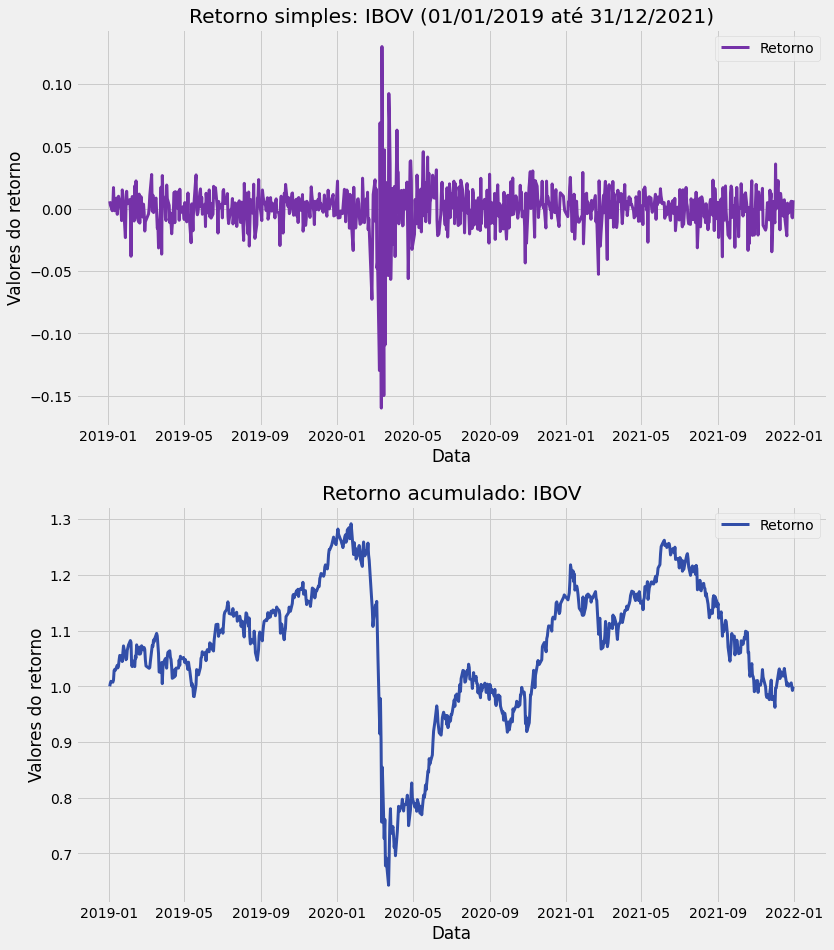

In [121]:
#Visualização

plt.figure(figsize=(12, 15));
plt.subplot(211);
plt.plot(retorno_simples_ibov, label='Retorno', color='#7532a8', linewidth=3);
plt.title('Retorno simples: IBOV (01/01/2019 até 31/12/2021)');
plt.ylabel('Valores do retorno');
plt.xlabel('Data');
plt.legend();

plt.subplot(212);
plt.plot(retorno_acumulado_ibov, label='Retorno', color='#324ea8', linewidth=3);
plt.title('Retorno acumulado: IBOV');
plt.ylabel('Valores do retorno');
plt.xlabel('Data');
plt.legend();

## Dados - ativo

In [122]:
#Dados - ativo

ativo = yf.download('PETR4.SA', start=inicio, end=fim)[['Close', 'Adj Close']]
ativo.head()

[*********************100%***********************]  1 of 1 completed


,Close,Adj Close
Date,,
2019-01-02,24.059999,18.925686
2019-01-03,24.650000,19.389782
2019-01-04,24.719999,19.444845
2019-01-07,25.110001,19.751617
2019-01-08,24.959999,19.633631


In [123]:
#Retorno simples - ativo

retorno_simples_ativo = np.log(ativo['Adj Close'] / ativo['Adj Close'].shift())
retorno_simples_ativo.head()

Date
2019-01-02         NaN
2019-01-03    0.024226
2019-01-04    0.002836
2019-01-07    0.015653
2019-01-08   -0.005991
Name: Adj Close, dtype: float64

In [124]:
#Retorno acumulado - ativo

retorno_acumulado_ativo = (1 + retorno_simples_ativo).cumprod()
retorno_acumulado_ativo.fillna(1, inplace=True)
retorno_acumulado_ativo.head()

Date
2019-01-02    1.000000
2019-01-03    1.024226
2019-01-04    1.027131
2019-01-07    1.043209
2019-01-08    1.036958
Name: Adj Close, dtype: float64

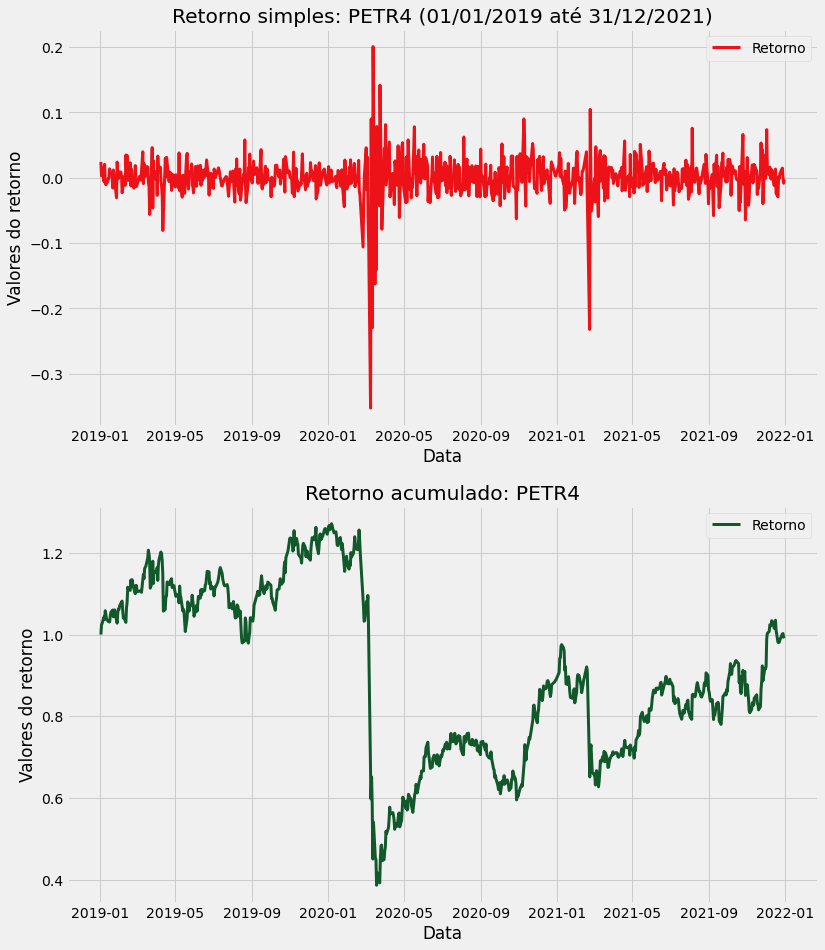

In [125]:
#Visualização

plt.figure(figsize=(12, 15));
plt.subplot(211);
plt.plot(retorno_simples_ativo, label='Retorno', color='#ed1118', linewidth=3);
plt.title('Retorno simples: PETR4 (01/01/2019 até 31/12/2021)');
plt.ylabel('Valores do retorno');
plt.xlabel('Data');
plt.legend();

plt.subplot(212);
plt.plot(retorno_acumulado_ativo, label='Retorno', color='#11592a', linewidth=3);
plt.title('Retorno acumulado: PETR4');
plt.ylabel('Valores do retorno');
plt.xlabel('Data');
plt.legend();

## Dados - Selic Meta

In [126]:
url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.432/dados?formato=json'

selic_meta = pd.read_json(url)

#Adaptando a base de dados

selic_meta['data'] = pd.to_datetime(selic_meta['data'], dayfirst=True)
selic_meta.set_index('data', inplace=True)
selic_meta.head()

,valor
data,
1999-03-05,45.0
1999-03-06,45.0
1999-03-07,45.0
1999-03-08,45.0
1999-03-09,45.0


In [152]:
#Ativo livre de risco

rf = selic_meta.iloc[-1]
rf

valor    9.25
Name: 2022-02-02 00:00:00, dtype: float64

# DataFrame para o CAPM para o retorno acumulado

In [128]:
capm = pd.DataFrame()
capm['Rf'] = rf[0]
capm['Rm'] = retorno_acumulado_ibov
capm['Ri'] = retorno_acumulado_ativo
capm['Rm - Rf'] = retorno_acumulado_ibov - rf[0]

for i in capm['Rf']:
    capm['Rf'] = rf[0]
    
capm.head()

,Rf,Rm,Ri,Rm - Rf
Date,,,,
2019-01-02,9.25,1.000000,1.000000,-8.250000
2019-01-03,9.25,1.006047,1.024226,-8.243953
2019-01-04,9.25,1.009086,1.027131,-8.240914
2019-01-07,9.25,1.007524,1.043209,-8.242476
2019-01-08,9.25,1.011176,1.036958,-8.238824


## Estimando o modelo com Statsmodels

In [129]:
#Estimação do modelo

y = capm['Ri']
x = capm['Rm - Rf']
#const = capm['Rf']

X = sm.add_constant(x)
resultado = sm.OLS(y, X).fit()

In [130]:
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Ri   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     440.1
Date:                Fri, 07 Jan 2022   Prob (F-statistic):           4.63e-77
Time:                        00:17:10   Log-Likelihood:                 285.66
No. Observations:                 743   AIC:                            -567.3
Df Residuals:                     741   BIC:                            -558.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5369      0.411     23.180      0.000       8.729      10.345
Rm - Rf        1.0552      0.050     20.979      0.000       0.956       1.154
==============================================================================
Omnibus:                     1344.433   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.139
Skew:                          -0.025   Prob(JB):                     4.77e-12
Kurtosis:                       1.703   Cond. No.                         564.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [131]:
#Parametros estimados

resultado.params

const      9.536869
Rm - Rf    1.055248
dtype: float64

## Estimando o modelo com Sklearn

In [132]:
#Redefinindo o formato da matriz

y = capm['Ri']
x = capm['Rm - Rf']

X = x.values.reshape(-1, 1)

In [133]:
#Estimação do modelo

reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [134]:
#R-square

reg.score(X, y)

0.3726201977986844

In [135]:
#Intercepto

reg.intercept_

9.53686928252706

In [136]:
#Coeficiente

reg.coef_[0]

1.055247890269945

In [137]:
#Previsão do modelo

y_chapeu = reg.predict(X)

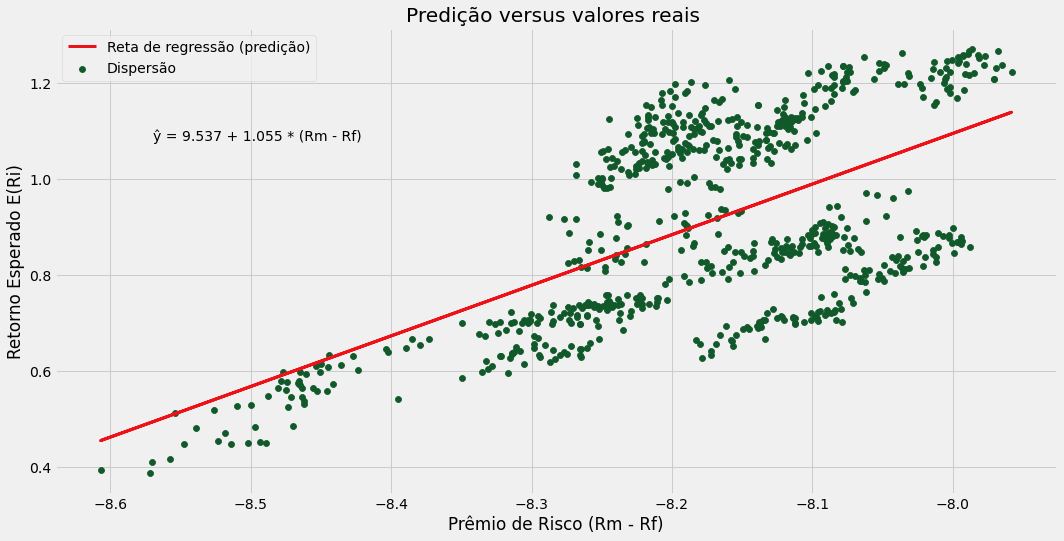

In [138]:
#Visualização

plt.figure(figsize=(16, 8));
plt.plot(x, y_chapeu, label='Reta de regressão (predição)', color='#ed1118', linewidth=3);
plt.scatter(x, y, label='Dispersão', color='#11592a', linewidth=0.8);
plt.title('Predição versus valores reais ');
plt.ylabel('Retorno Esperado E(Ri)');
plt.xlabel('Prêmio de Risco (Rm - Rf)');
plt.text(-8.57, 1.08, f'ŷ = {np.round(reg.intercept_, 3)} + {np.round(reg.coef_[0], 3)} * (Rm - Rf)');
plt.legend();

# DataFrame para o CAPM para o retorno simples

In [139]:
capm_simples = pd.DataFrame()
capm_simples['Rf'] = rf[0]
capm_simples['Rm'] = retorno_simples_ibov
capm_simples['Ri'] = retorno_simples_ativo
capm_simples['Rm - Rf'] = retorno_simples_ibov - rf[0]

for i in capm_simples['Rf']:
    capm_simples['Rf'] = rf[0]
    
capm_simples.dropna(inplace=True)
    
capm_simples.head()

,Rf,Rm,Ri,Rm - Rf
Date,,,,
2019-01-03,9.25,0.006047,0.024226,-9.243953
2019-01-04,9.25,0.003021,0.002836,-9.246979
2019-01-07,9.25,-0.001547,0.015653,-9.251547
2019-01-08,9.25,0.003625,-0.005991,-9.246375
2019-01-09,9.25,0.017033,0.020619,-9.232967


## Estimando o modelo com Satasmodels

In [140]:
#Estimação do modelo

y1 = capm_simples['Ri']
x1 = capm_simples['Rm - Rf']
#const = capm['Rf']

X1 = sm.add_constant(x1)
resultado1 = sm.OLS(y1, X1).fit()

In [141]:
resultado1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Ri   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     1484.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):          4.95e-179
Time:                        00:17:12   Log-Likelihood:                 1902.1
No. Observations:                 742   AIC:                            -3800.
Df Residuals:                     740   BIC:                            -3791.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6467      0.328     38.531      0.000      12.002      13.291
Rm - Rf        1.3672      0.035     38.529      0.000       1.298       1.437
==============================================================================
Omnibus:                      372.853   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10935.181
Skew:                          -1.661   Prob(JB):                         0.00
Kurtosis:                      21.511   Cond. No.                     4.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [142]:
#Parametros estimados

resultado1.params

const      12.646706
Rm - Rf     1.367180
dtype: float64

## Estimando o modelo com Sklearn

In [143]:
#Redefinindo o formato da matriz

y1 = capm_simples['Ri']
x1 = capm_simples['Rm - Rf']

X1 = x1.values.reshape(-1, 1)

In [144]:
#Estimação do modelo

reg1 = LinearRegression()
reg1.fit(X1, y1)

LinearRegression()

In [145]:
#Intercepto

reg1.intercept_

12.646705813570016

In [146]:
#Coeficiente

reg1.coef_[0]

1.3671801894401678

In [150]:
#Previsão do modelo

y_chapeu1 = reg1.predict(X1)

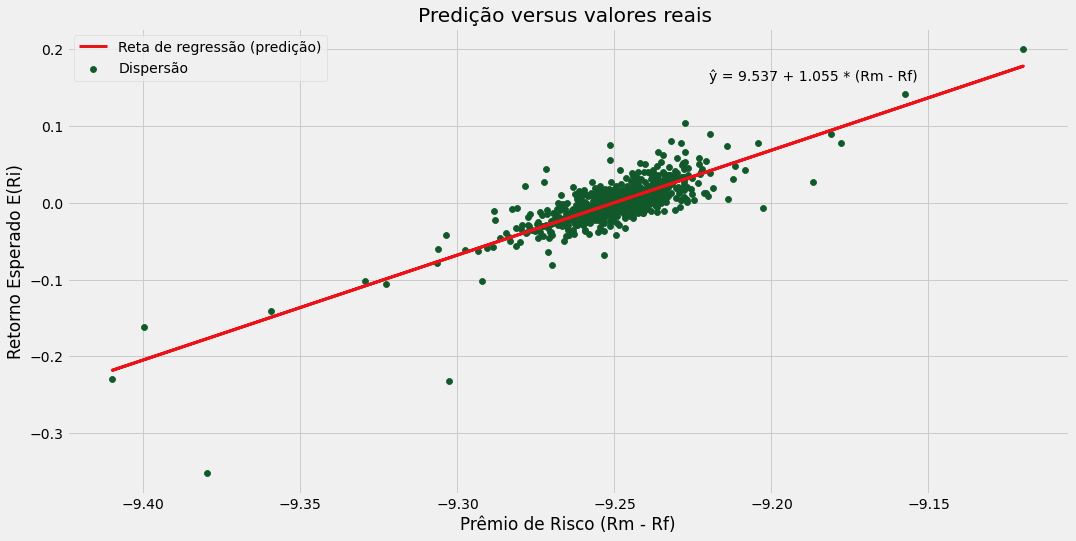

In [151]:
plt.figure(figsize=(16, 8));
plt.plot(x1, y_chapeu1, label='Reta de regressão (predição)', color='#ed1118', linewidth=3);
plt.scatter(x1, y1, label='Dispersão', color='#11592a', linewidth=0.8);
plt.title('Predição versus valores reais ');
plt.ylabel('Retorno Esperado E(Ri)');
plt.xlabel('Prêmio de Risco (Rm - Rf)');
plt.text(-9.22, 0.16, f'ŷ = {np.round(reg.intercept_, 3)} + {np.round(reg.coef_[0], 3)} * (Rm - Rf)');
plt.legend();

SCRIP FINALIZADO!